In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from scvi.hub import HubModel
from botocore.config import Config
import botocore

model = HubModel.pull_from_s3(
    s3_bucket="cellxgene-contrib-public",
    s3_path="models/scvi/2024-02-12/homo_sapiens/modelhub",
    pull_anndata=False,
    config=Config(signature_version=botocore.UNSIGNED),
)

In [3]:
import anndata

# load the query data
adata = anndata.read_h5ad(
    "../data/RNA/raw/train/cellxgene_pseudo_bulk_3_5k.h5ad", backed="r"
)

In [4]:
import os
import tempfile
import scanpy as sc

# To load the scvi model, you need the original training data
save_dir = tempfile.TemporaryDirectory()
adata_path = os.path.join(save_dir.name, "adata-spinal-cord-minified.h5ad")

adata_og = sc.read(
    adata_path,
    backup_url="https://cellxgene-contrib-public.s3.amazonaws.com/models/scvi/2024-02-12/homo_sapiens/adata-spinal-cord-minified.h5ad",
)

  0%|          | 0.00/45.1M [00:00<?, ?B/s]

In [8]:
with open("../resources/gene_selection_ENSG_8k.txt", "w") as f:
    for gene in adata_og.var.index:
        f.write(f"{gene}\n")

In [24]:
# Get intersection of var_names between the two datasets
common_genes = list(set(adata.var_names).intersection(set(adata_og.var_names)))
print(f"Number of common genes: {len(common_genes)}")

Number of common genes: 5619


You have to load the model with part of the data it was trained on. 

In [31]:
del adata_og.uns["_scvi_adata_minify_type"]
model.load_model(adata=adata_og[adata_og.obs["is_primary_data"]].copy())
census_model = model.model

INFO     Loading model...                                                                                          
INFO     File /var/folders/x3/bj_4mgb56c19542qzptvc36c0000gn/T/tmp_ej9pau_/model.pt already downloaded             


/Users/mengerj/repos/adata_hf_datasets/.venv/lib/python3.12/site-packages/scvi/model/base/_base_model.py:692: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator=='mps' in train function.In future releases it will become default for mps supported machines.
  _, _, device = parse_device_args(
/Users/mengerj/repos/adata_hf_datasets/.venv/lib/python3.12/site-packages/scvi/model/_scvi.py:159: UserWarning: This dataset has some empty cells, this might fail inference.Data should be filtered with `scanpy.pp.filter_cells()`
  library_log_means, library_log_vars = _init_library_size(


## preprare the query anndata
This will get the intersection of gene_names (make sure .var_names have the same kind of gene names as in adata_og) and it will pad missing genes if there arent enough from the intersection. 

In [133]:
import scvi

scvi.model.SCVI.prepare_query_anndata(adata, census_model)

INFO     Found 70.2375% reference vars in query data.                                                              


/Users/mengerj/repos/adata_hf_datasets/.venv/lib/python3.12/site-packages/scvi/model/base/_archesmixin.py:211: UserWarning: Query data contains less than 80% of reference var names. This may result in poor performance.
  return _pad_and_sort_query_anndata(adata, var_names, inplace)


In [103]:
from pandas.api.types import is_numeric_dtype, is_categorical_dtype


def fix_non_numeric_nans(adata):
    """
    For each column in adata.obs that is not strictly numeric,
    replace NaN with 'unknown'. This prevents mixed float/string
    issues that scvi can run into when sorting categorical columns.

    Parameters
    ----------
    adata : anndata.AnnData
        The AnnData object to fix in-place. Must have .obs attribute.

    Notes
    -----
    - If the column is categorical, we first add a new category 'unknown'
      (if not present) before calling .fillna().
    - If the column is object/string dtype, we convert to string and
      fill missing values with 'unknown'.
    - Numeric columns are left untouched.
    """

    for col in adata.obs.columns:
        if is_numeric_dtype(adata.obs[col]):
            # strictly numeric -> do nothing
            continue

        if is_categorical_dtype(adata.obs[col]):
            # For a categorical column, we must add a new category
            # before filling with it
            if "unknown" not in adata.obs[col].cat.categories:
                adata.obs[col] = adata.obs[col].cat.add_categories(["unknown"])
            adata.obs[col] = adata.obs[col].fillna("unknown")
        else:
            # For object/string columns, cast to str, then fillna
            adata.obs[col] = adata.obs[col].astype(str).fillna("unknown")

Padding of genes introduces many Nans into the obs columns. Change any nans into "unknown" for categorial columns.

In [134]:
fix_non_numeric_nans(adata)

/var/folders/x3/bj_4mgb56c19542qzptvc36c0000gn/T/ipykernel_67835/2283494839.py:29: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if is_categorical_dtype(adata.obs[col]):


A new model instance based on the query data can be built with the load_query_data function. The weights should remain the same and is_trained needs to be set to true manually. 


In [135]:
import scvi

census_model_query = scvi.model.SCVI.load_query_data(adata, census_model)
census_model_query.is_trained = True

/Users/mengerj/repos/adata_hf_datasets/.venv/lib/python3.12/site-packages/scvi/model/base/_archesmixin.py:85: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator=='mps' in train function.In future releases it will become default for mps supported machines.
  _, _, device = parse_device_args(
/Users/mengerj/repos/adata_hf_datasets/.venv/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:224: UserWarning: Category 6008 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(


In [136]:
embeds = census_model_query.get_latent_representation()

In [139]:
adata.obsm["pre-trained_emb"] = embeds

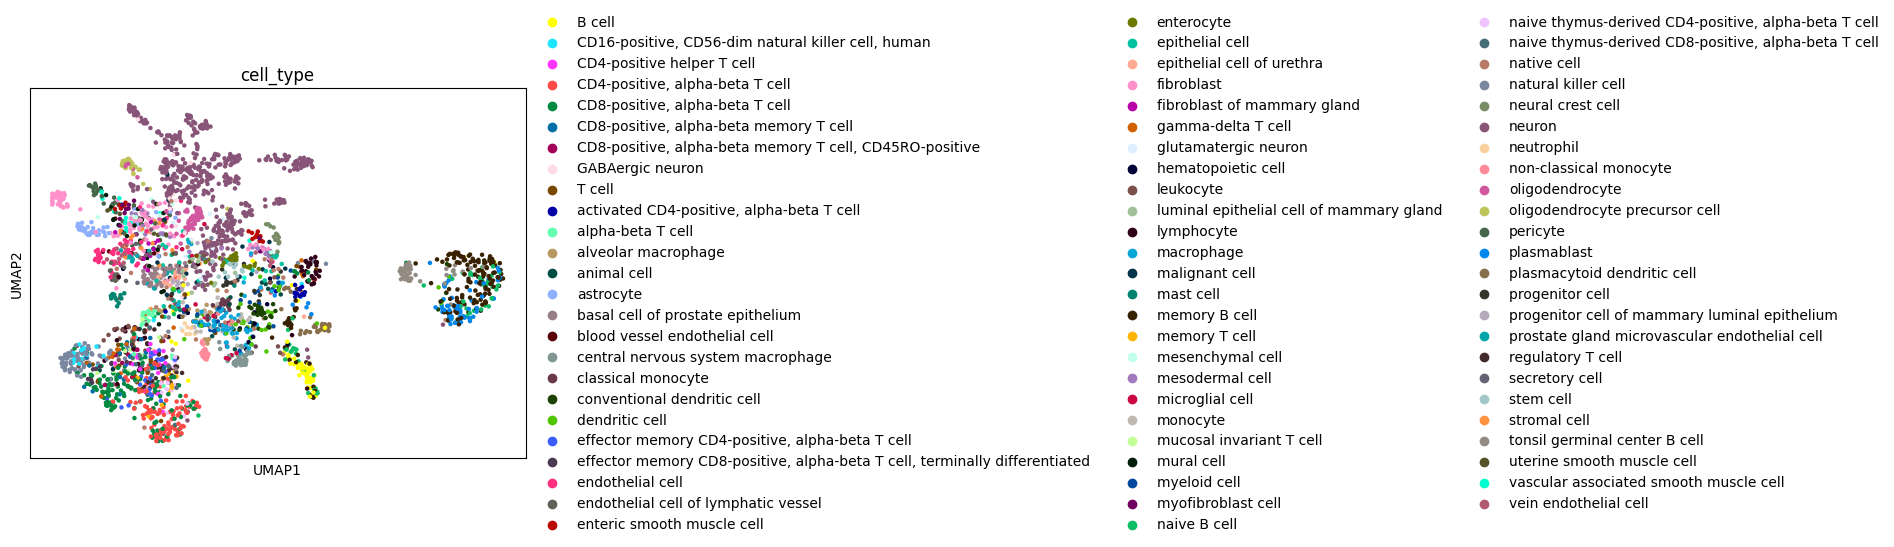

In [144]:
from adata_hf_datasets.utils import consolidate_low_frequency_categories

color_key = "cell_type"
# adata_cut = adata.copy()
adata_cut = consolidate_low_frequency_categories(
    adata, columns=color_key, threshold=10, remove=True
)
sc.pp.neighbors(adata_cut, n_neighbors=20, use_rep="pre-trained_emb")
sc.tl.umap(adata_cut)
sc.pl.umap(adata_cut, color=[color_key], ncols=1)